# Task 2: Necessary and Sufficient Explanations

In [3]:
import os
import pandas as pd
import textstat
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from dotenv import load_dotenv
load_dotenv()

from sentence_transformers import SentenceTransformer, util

from openai import OpenAI

ModuleNotFoundError: No module named 'dotenv'

## 1. Load & Filter Data
We decided to create golden explanations for the first Question.ID for each failing method. That means that we have 8 instances with 6-18 answers each.

In [ ]:
data = pd.read_csv("data/answerList_data.csv")

# Filter to include only rows where TP == 1 or TN == 1
filtered_data = data[(data["TP"] == 1) | (data["TN"] == 1)]
print("Filtered data shape:", filtered_data.shape)

Filtered data shape: (1629, 25)


In [28]:
df_golden = pd.read_csv("intermediate/task_02_golden_explanations.csv")
print("Golden explanations shape:", df_golden.shape)

Golden explanations shape: (8, 2)


In [2]:
df_golden

NameError: name 'df_golden' is not defined

In [4]:
merged_df = filtered_data.merge(df_golden, on="Question.ID", how="inner")
print("Merged shape (answers + gold):", merged_df.shape)

Merged shape (answers + gold): (101, 26)


## 2. Group Explanations by Question.ID
We'll create a dataframe with golden explanations and all answers in a list so that we can iteratively add from the list to the LLM prompt.

In [5]:
grouped_explanations = (
    merged_df.groupby("Question.ID")
    .agg({
        "Answer.explanation": list,
        "golden_explanation": "first",
    })
    .reset_index()
)

print("Number of unique question IDs:", grouped_explanations.shape[0])
grouped_explanations.head()

Number of unique question IDs: 8


,Question.ID,Answer.explanation,golden_explanation
0,0,[hoursOffset accepts negative numbers between ...,"The issue is `minutesOffset` variable, not the..."
1,10,[g has to be 0-255. But you are passing in -0....,"The issue is `value`, which results in `g` bei..."
2,16,[CharSequence is a base class for a number of ...,The reason for `StringIndexOutOfBoundsExceptio...
3,33,"[the ""period"" variable is used to set the star...",`period` is correctly used in the program. It ...
4,70,[The variable array is defined as an array of ...,`array` is correctly defined as a generic arra...


## 3. Generate Consolidated Explanations & Metrics

In [9]:
# We use the default sentence transformer model for this task
st_model = SentenceTransformer("all-MiniLM-L6-v2")

In [10]:
# Create the client
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

def get_llm_consolidation(explanations_subset, prompt_text):
    """
    Given a batch of human explanations (explanations_text) and a prompt_text,
    calls the LLM to generate a consolidated explanation.
    """
    explanations_text = "\n".join(explanations_subset)
    # Build a full prompt, combining the "prompt_text" plus the actual lines
    full_prompt = f"""{prompt_text}

Here are the explanations each separated by a newline:
{explanations_text}
    """
    try:
        response = client.chat.completions.create(
            messages=[{"role": "user", "content": full_prompt}],
            model="gpt-4o-mini", 
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        print("OpenAI API call failed:", e)
        return None

In [11]:
def get_reading_ease_score(text):
    """
    Compute Flesch Reading Ease score via textstat.
    Higher = easier to read. Our threshold is >= 60.
    """
    return textstat.flesch_reading_ease(text)

def get_cosine_similarity(text_a, text_b):
    """
    Encode the two texts using a sentence-transformers model
    and return the cosine similarity (0 to 1).
    """
    embeddings = st_model.encode([text_a, text_b], convert_to_tensor=True)
    sim = util.pytorch_cos_sim(embeddings[0], embeddings[1])
    return float(sim.item())  

## 3. Minimal Subset Selection (Naive Strategy)
We naively add more explanations to the prompt so that the LLM has more information to generate a consolidated answer that is close to the golden answer.

In [12]:
PROMPT = """You have multiple bug explanations from different programmers.
Your task is to merge them into a single explanation that:
1) Contains all necessary details to understand and fix the bug,
2) Avoids redundancy and repeats,
3) Is concise and readable.
"""

READABILITY_THRESHOLD = 60.0
SIMILARITY_THRESHOLD = 0.85

log_rows = []
results = []

for idx, row in tqdm(grouped_explanations.iterrows(), total=grouped_explanations.shape[0], desc="Processing QIDs"):
    qid = row["Question.ID"]
    explanations = row["Answer.explanation"]
    gold_text = row["golden_explanation"]
    
    total_explanations = len(explanations)
    chosen_subset = []
    
    final_text = ""
    final_reading_ease = 0.0
    final_similarity = 0.0
    
    for subset_size, expl in enumerate(explanations, start=1):
        chosen_subset.append(expl)

        # Consolidate with LLM
        candidate_text = get_llm_consolidation(chosen_subset, PROMPT)

        re_score = get_reading_ease_score(candidate_text)
        sim_score = get_cosine_similarity(candidate_text, gold_text)

        # Log the partial result
        log_rows.append({
            "Question.ID": qid,
            "subset_size": subset_size,
            "total_explanations": total_explanations,
            "candidate_text": candidate_text,
            "reading_ease": re_score,
            "similarity": sim_score,
        })

        final_text = candidate_text
        final_reading_ease = re_score
        final_similarity = sim_score
    
    # Store final result
    results.append({
        "Question.ID": qid,
        "total_explanations": total_explanations,
        "num_explanations_used": subset_size,
        "final_consolidation": final_text,
        "flesch_reading_ease": final_reading_ease,
        "cosine_similarity": final_similarity,
    })

df_log = pd.DataFrame(log_rows)
df_log.to_csv("intermediate/task_02_intermediate_log.csv", index=False)

df_results = pd.DataFrame(results)
df_results.to_csv("intermediate/task_02_minimal_subset_results.csv", index=False)

df_results.head()


Processing QIDs: 100%|██████████| 8/8 [05:54<00:00, 44.34s/it]


,Question.ID,total_explanations,num_explanations_used,final_consolidation,flesch_reading_ease,cosine_similarity
0,0,16,16,The bug pertains to a conditional error in the...,37.94,0.867696
1,10,9,9,The bug arises from improper handling of color...,58.48,0.800423
2,16,14,14,The bug appears to be related to an index out ...,42.51,0.818070
3,33,13,13,"The ""period"" variable is defined correctly as ...",43.73,0.781655
4,70,14,14,The bug arises from a type casting issue in th...,48.23,0.858057


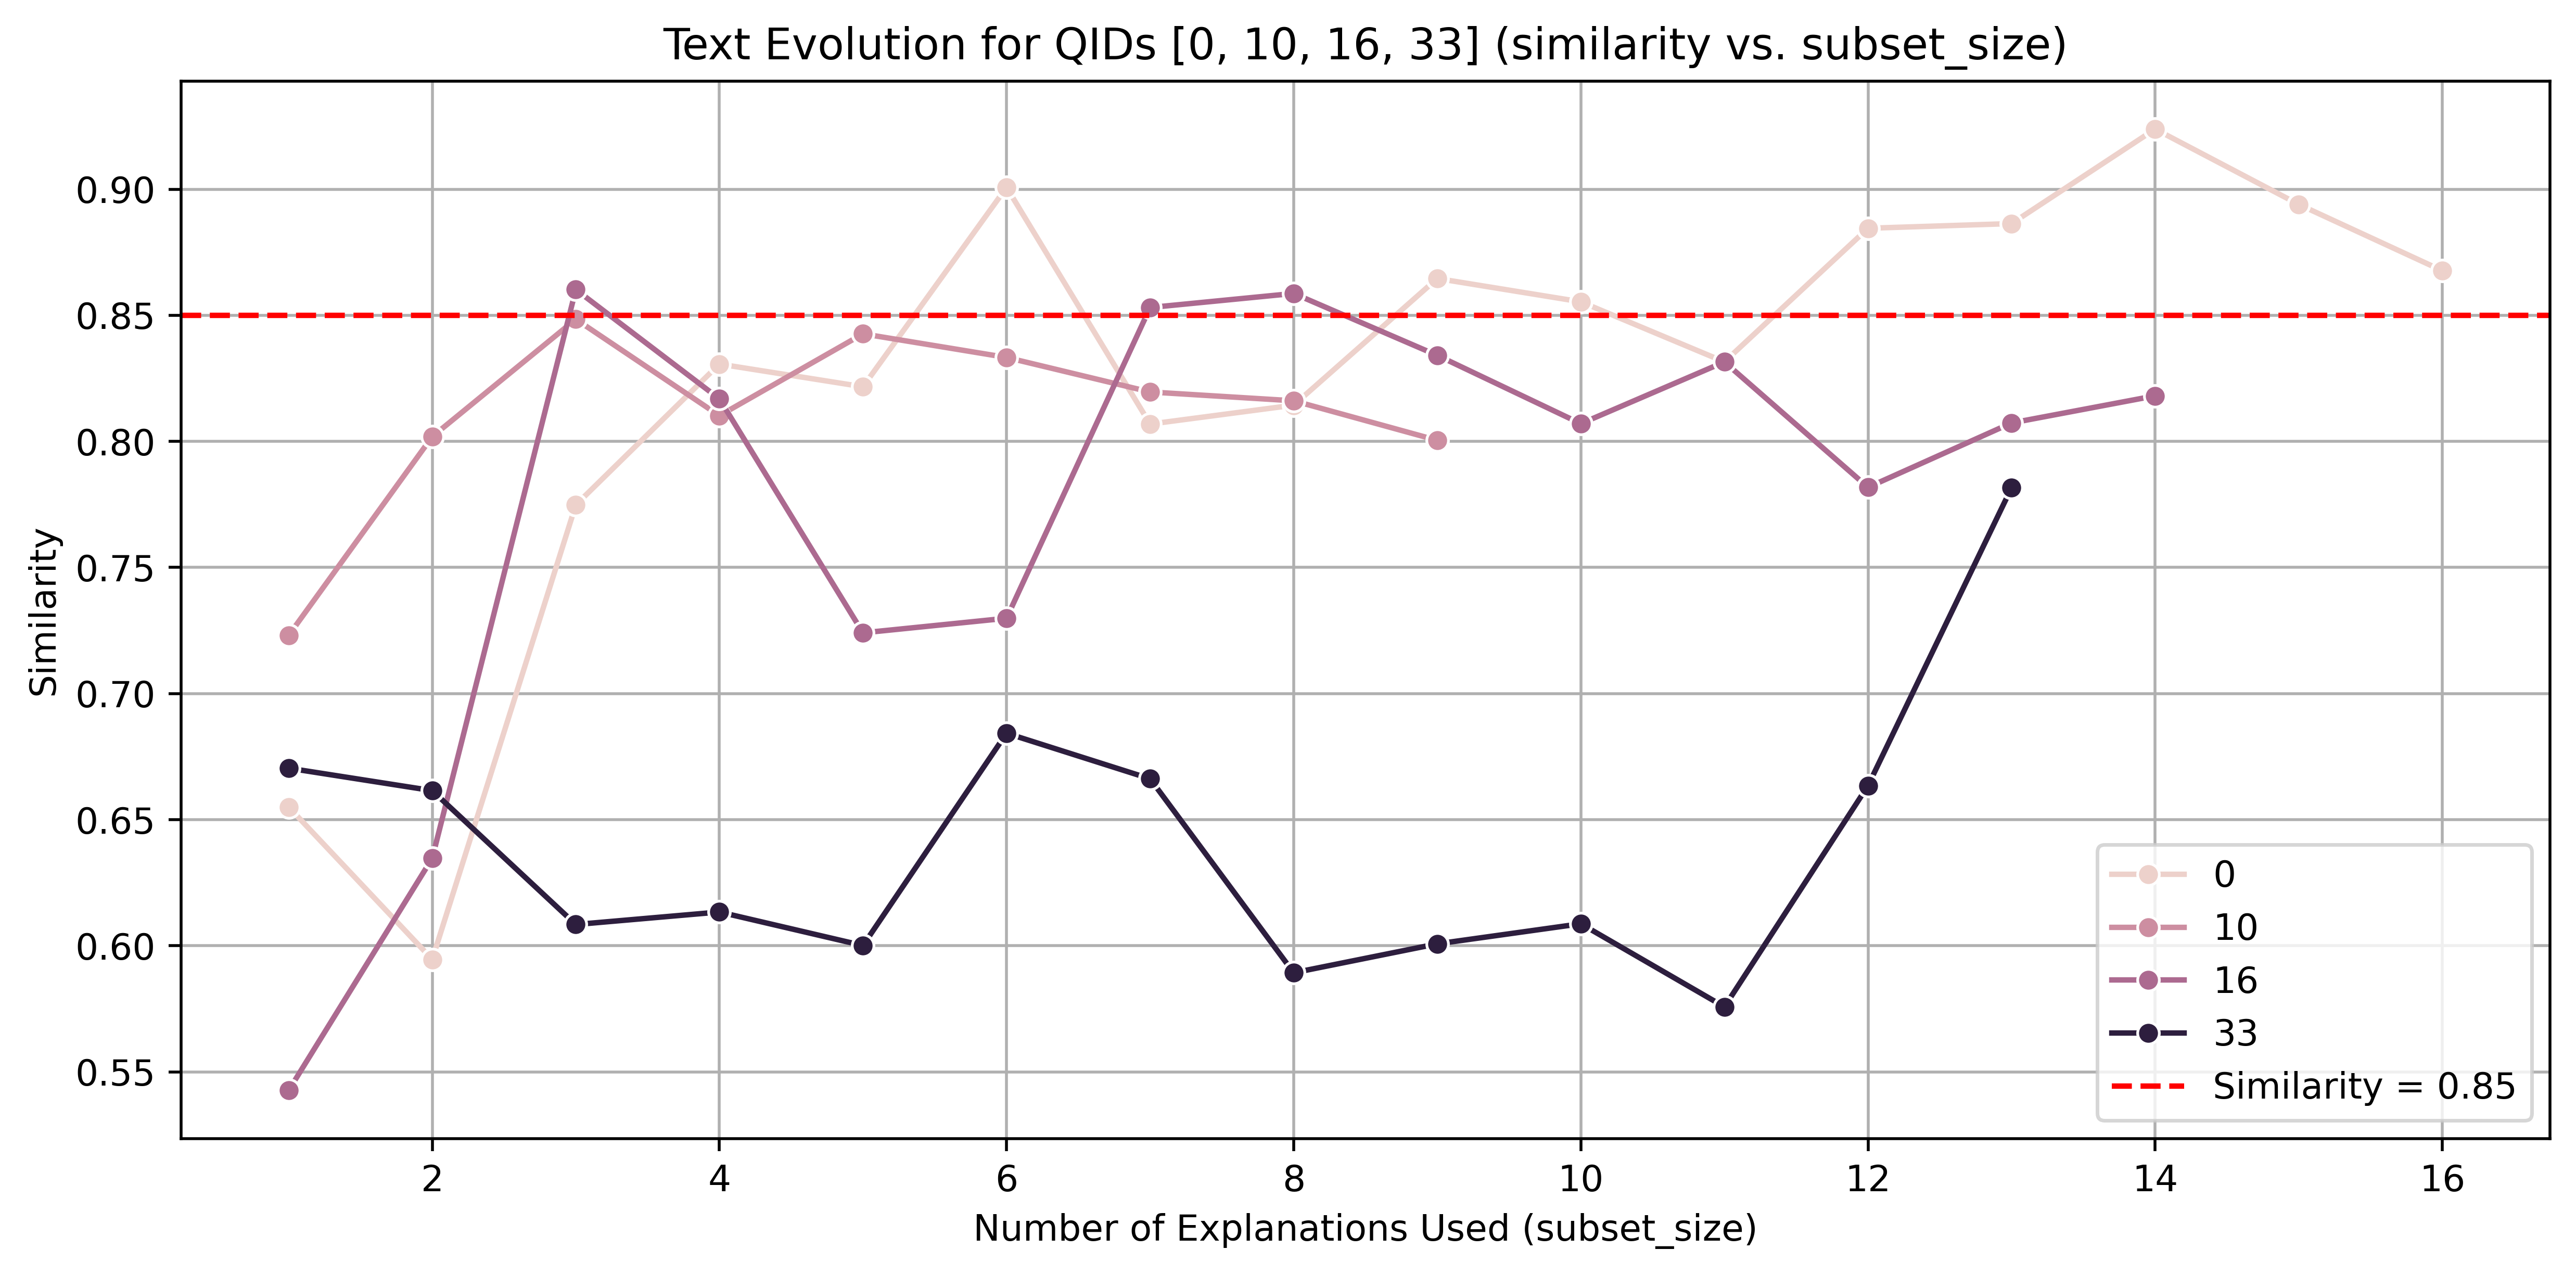

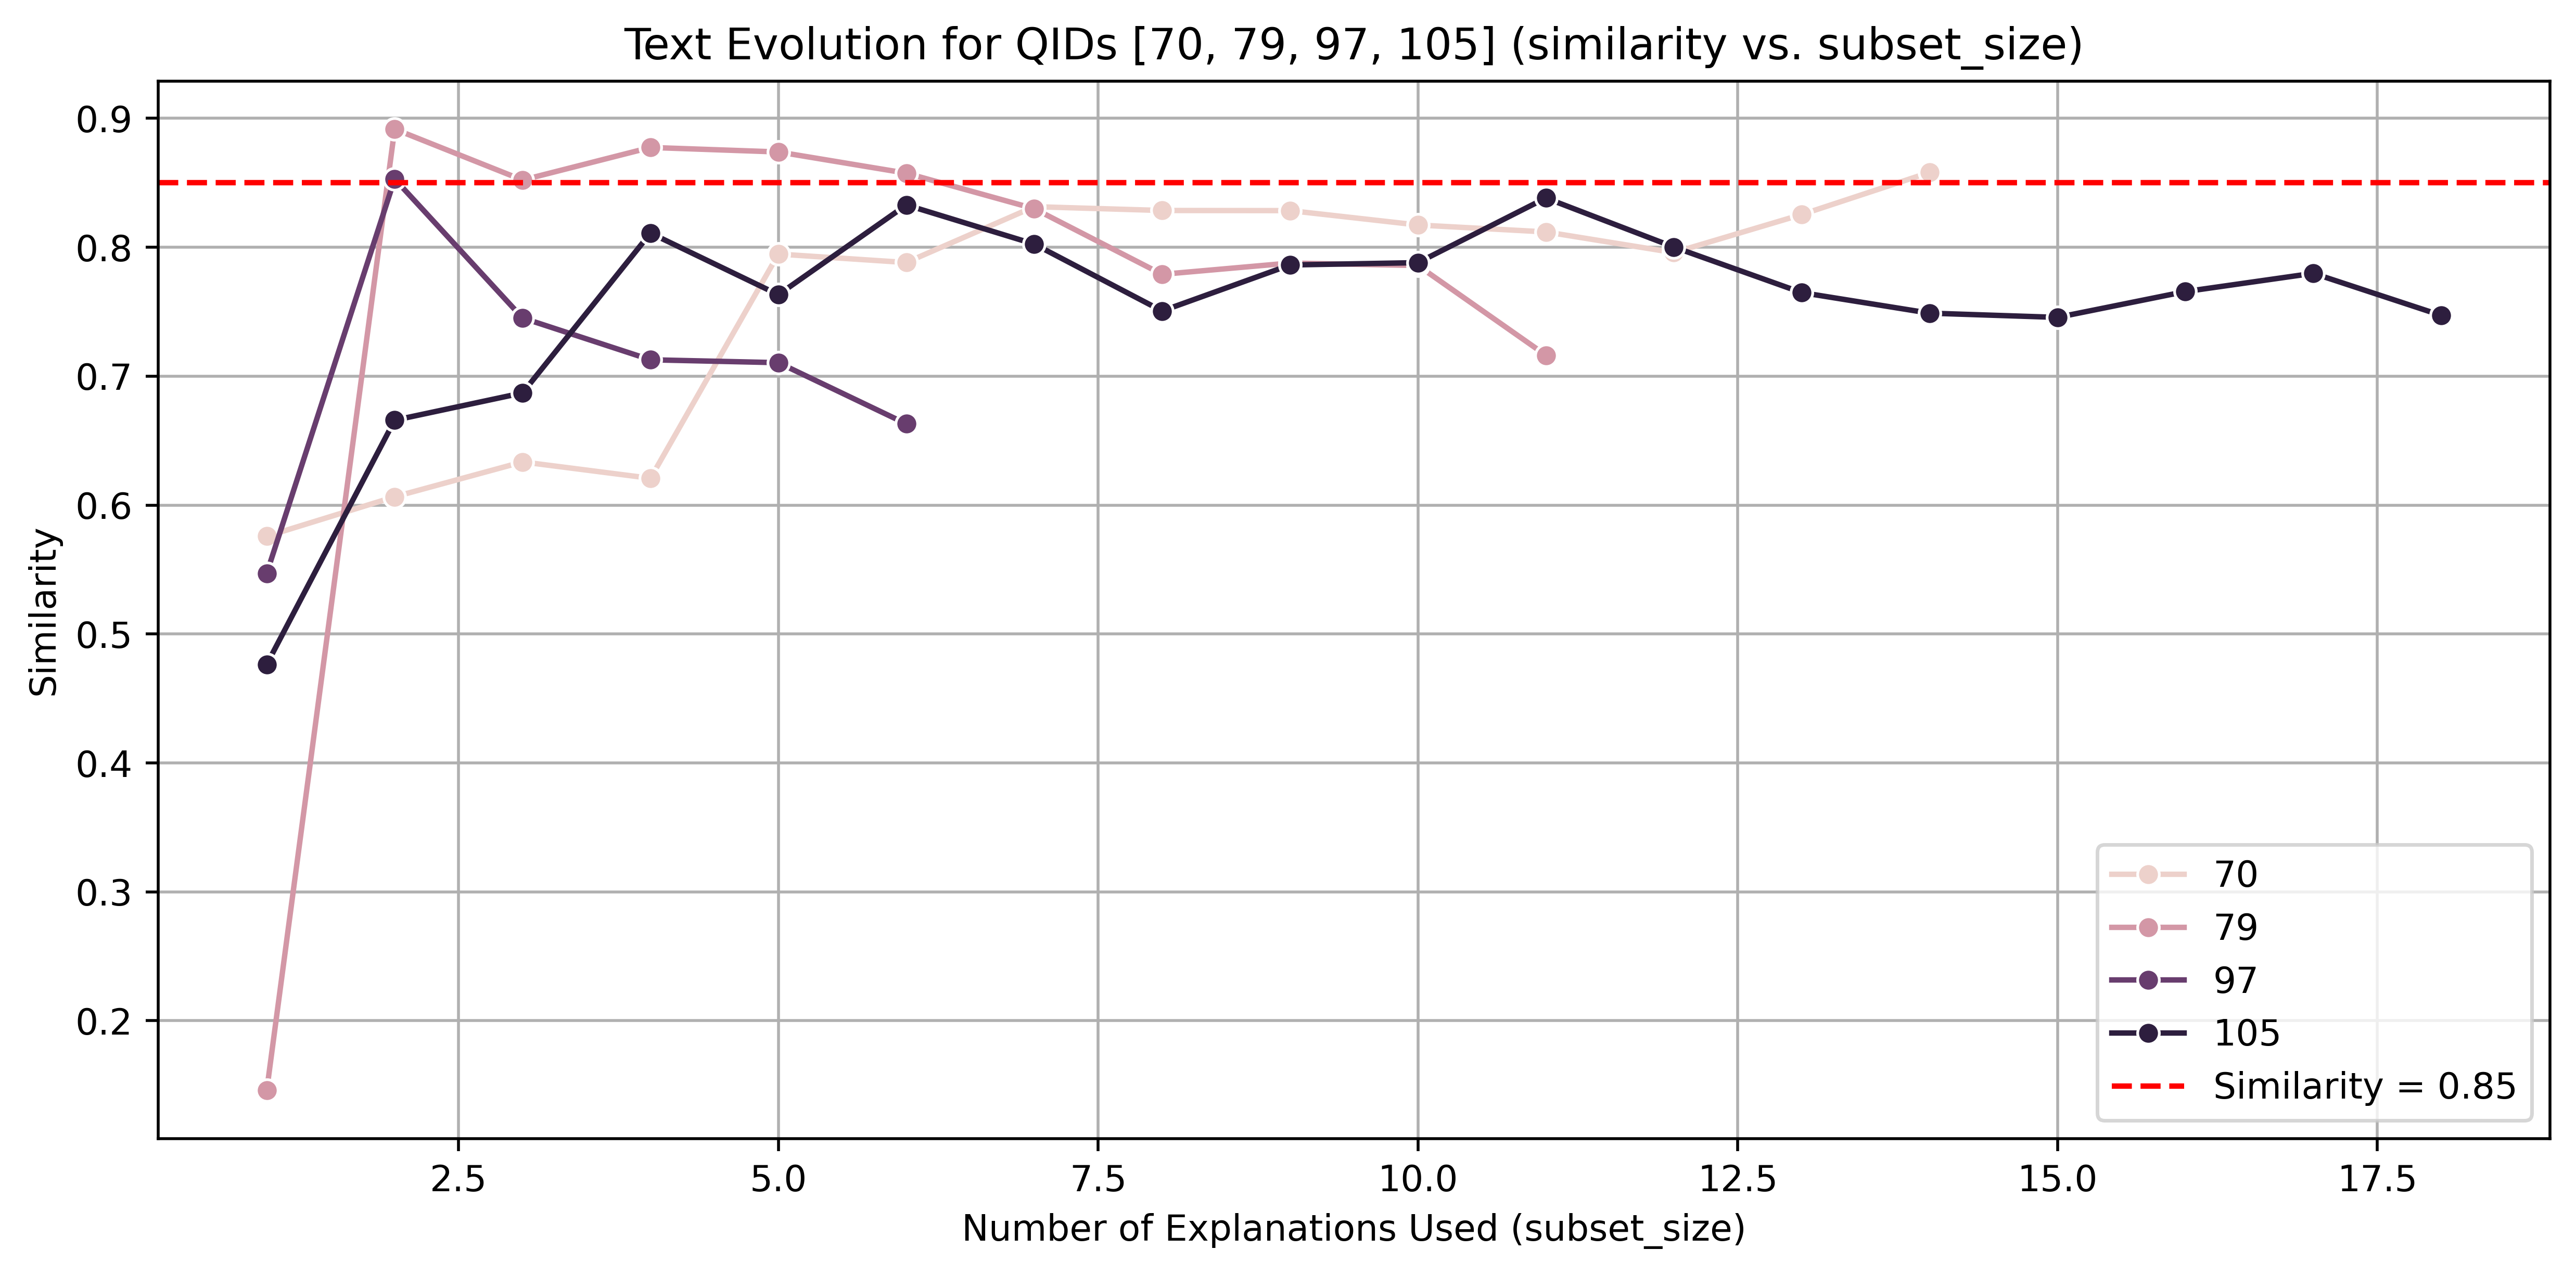

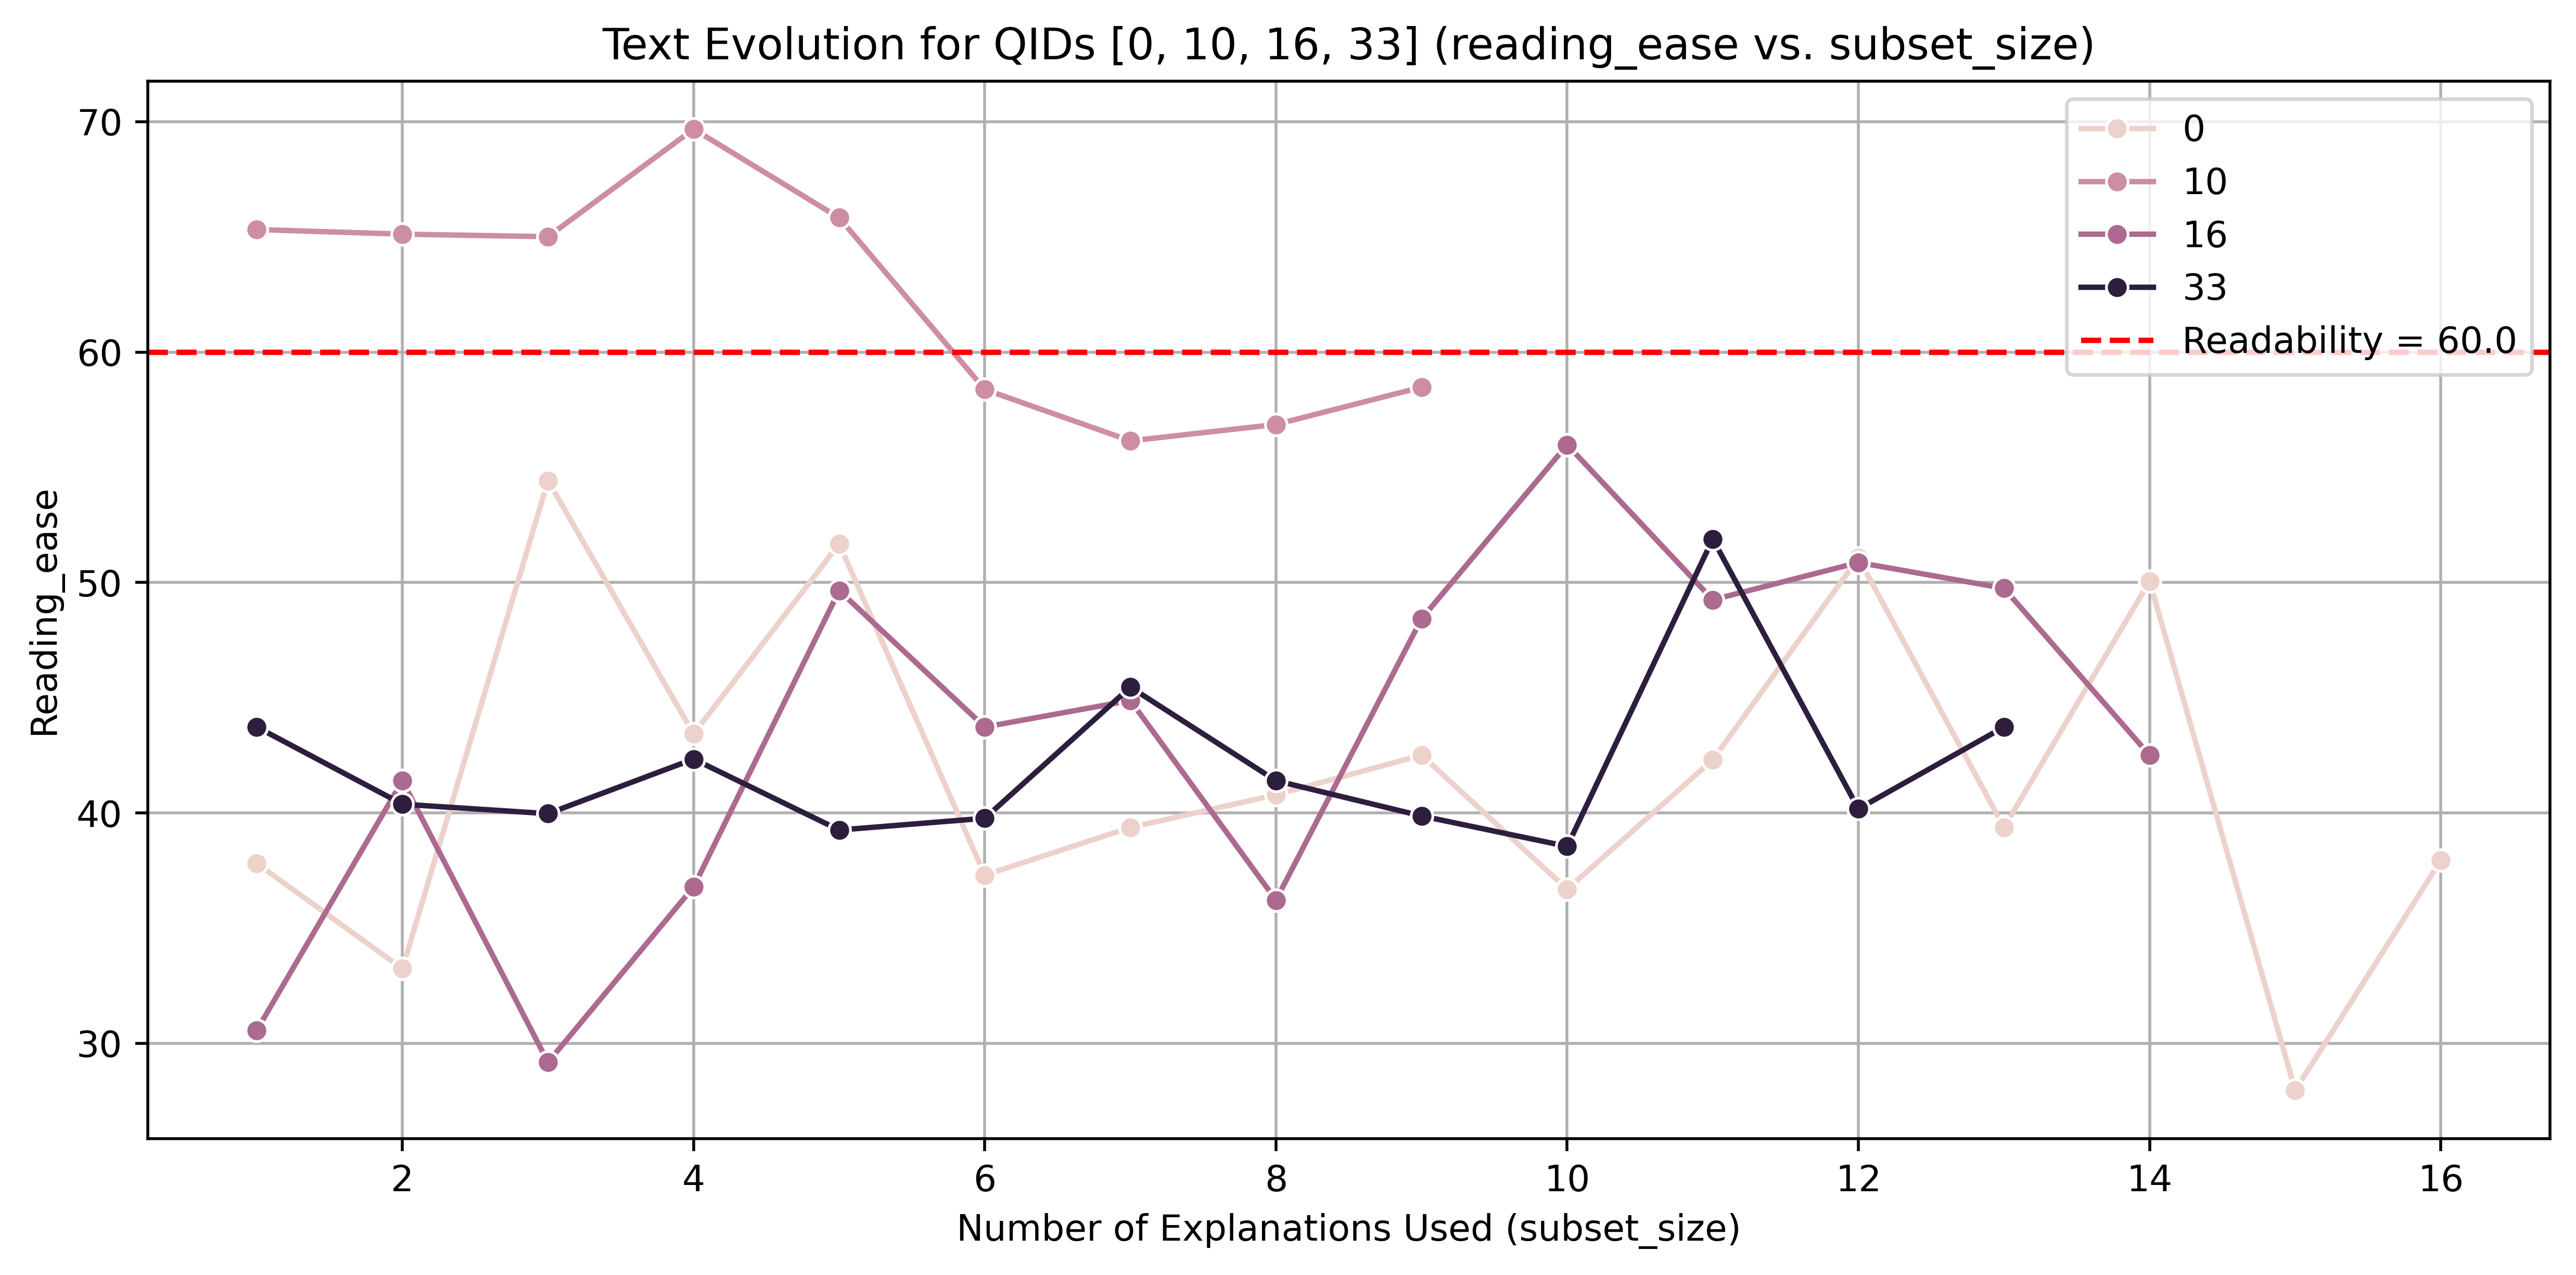

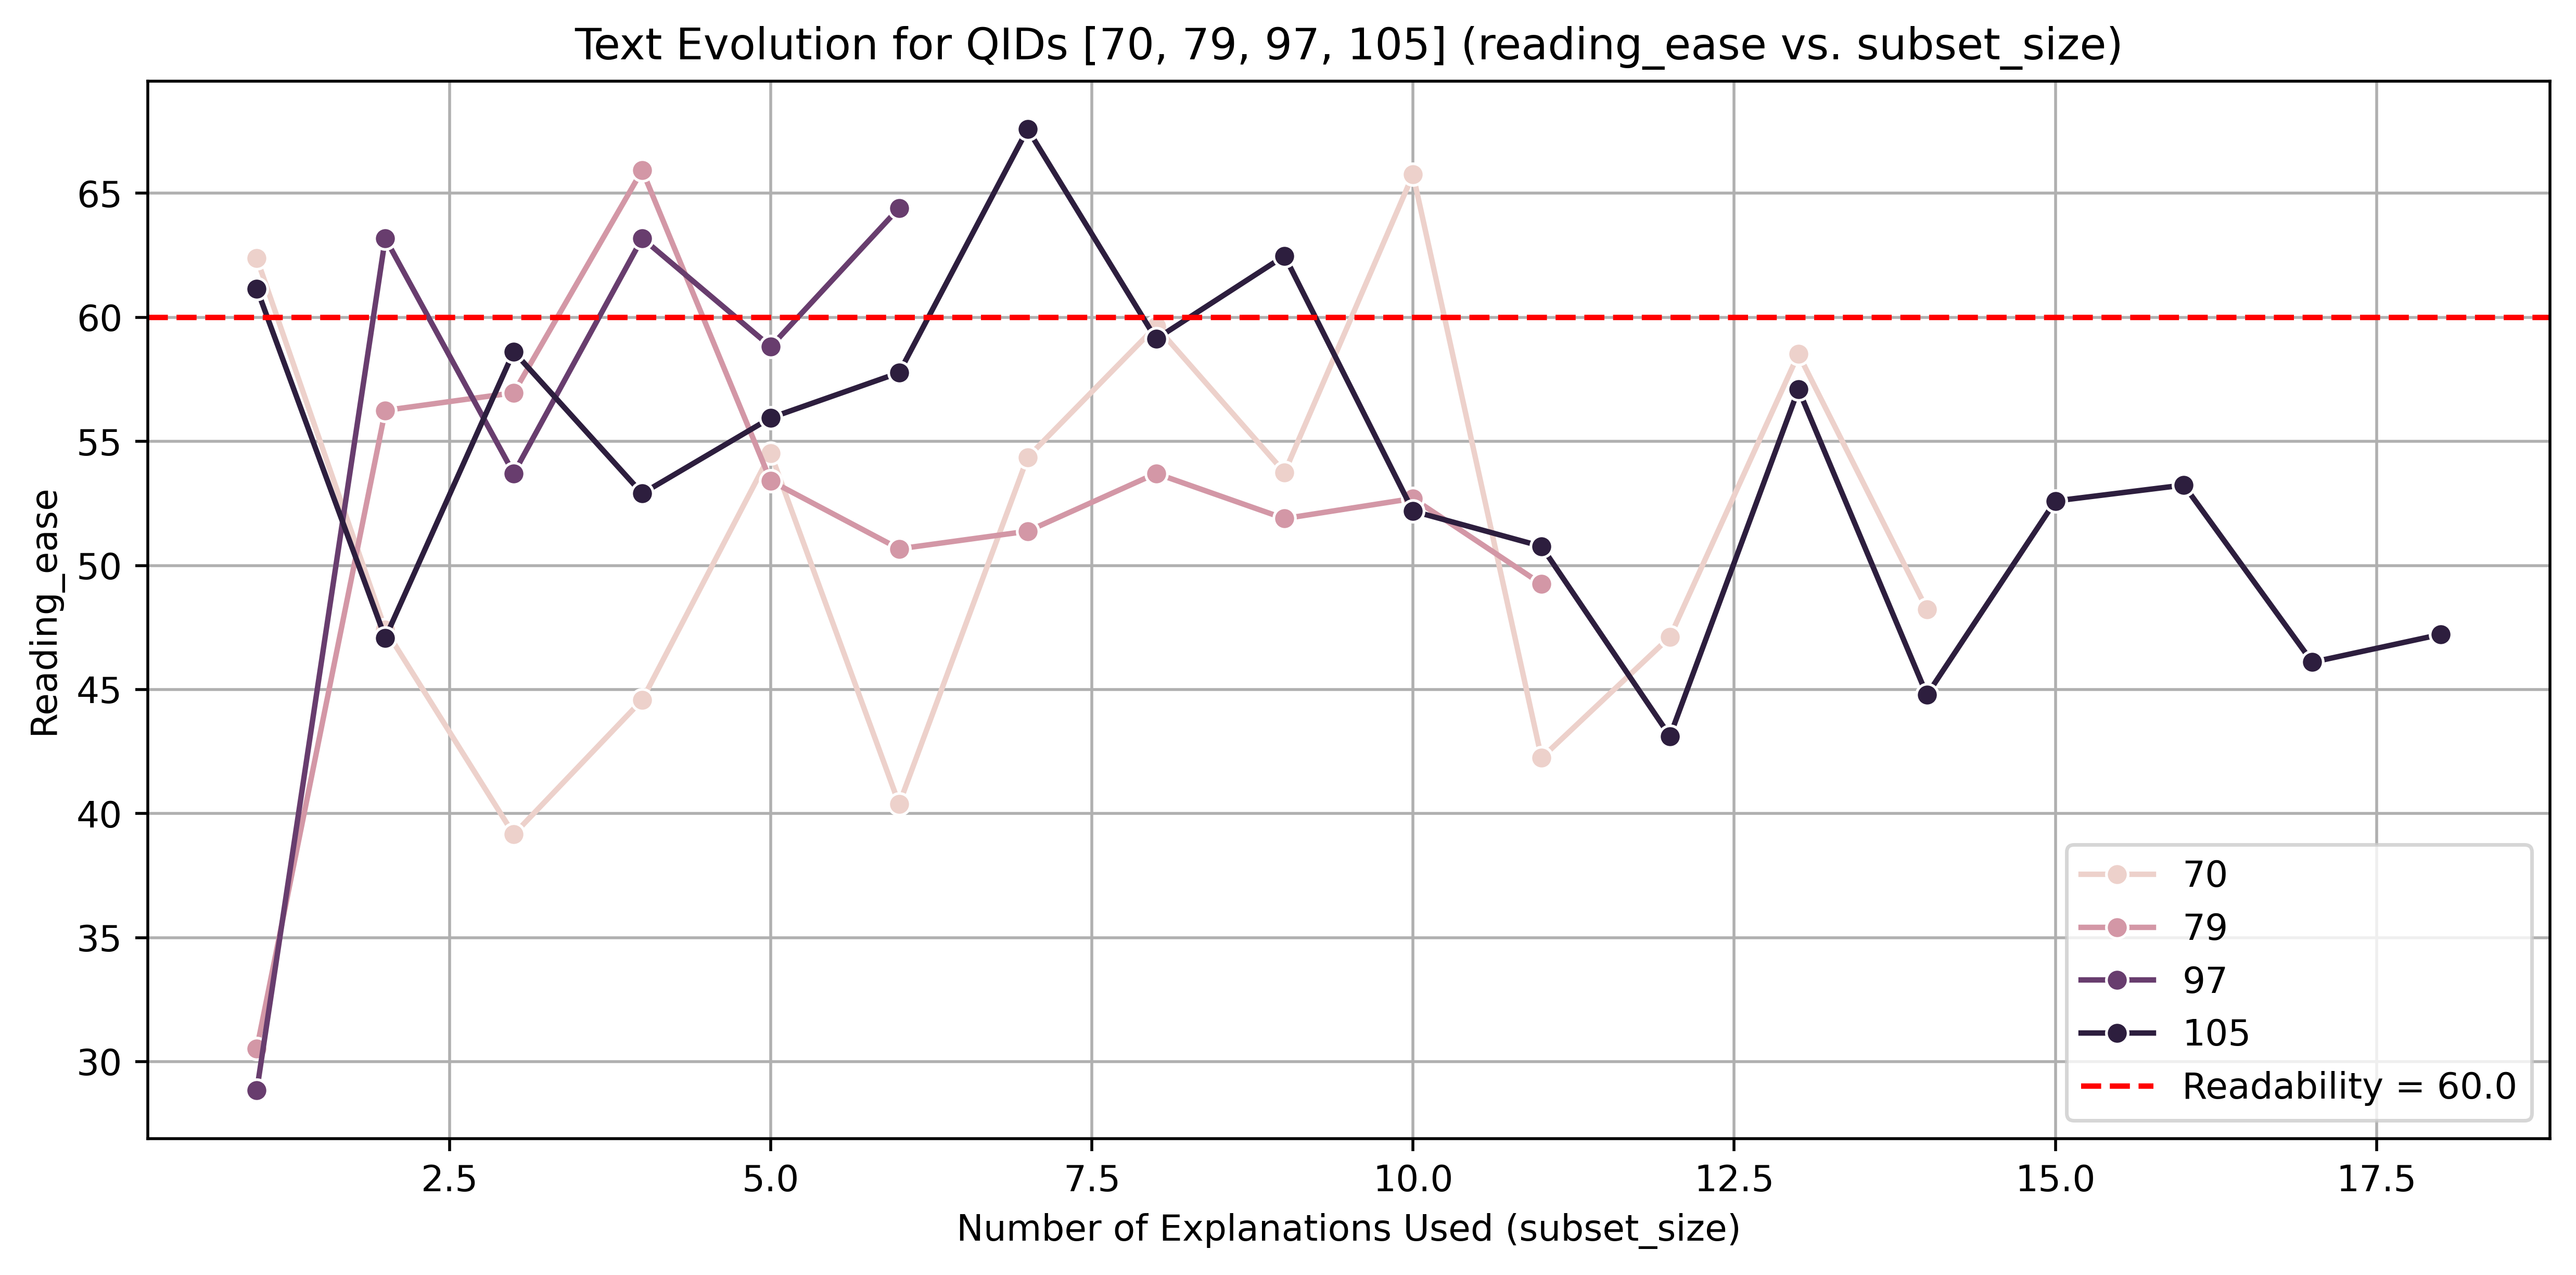

In [25]:
def plot_text_evolution(
    df_log, 
    question_ids, 
    metric="similarity",
    similarity_threshold=0.85,
    readability_threshold=60.0
):
    """
    Plot how the candidate text changes for multiple Question.IDs by showing
    subset_size vs. a chosen metric (e.g., "similarity", "reading_ease") in one plot.
    
    Args:
        df_log (pd.DataFrame):
            Must have columns ["Question.ID", "subset_size", "candidate_text", metric].
        question_ids (list or set):
            A list (or set) of Question.IDs you want to visualize in the same figure.
        metric (str):
            The metric column name to plot on the y-axis ("similarity", "reading_ease", etc.).
        similarity_threshold (float):
            Draws a horizontal line if metric == "similarity".
        readability_threshold (float):
            Draws a horizontal line if metric == "reading_ease".
    """
    # Filter down to only the rows with those Question.IDs
    df_subset = df_log[df_log["Question.ID"].isin(question_ids)].copy()
    if df_subset.empty:
        print(f"No rows found for any of the specified Question.IDs: {question_ids}")
        return
    
    df_subset.sort_values(["Question.ID", "subset_size"], inplace=True)

    plt.figure(figsize=(10, 5), dpi=500)
    sns.lineplot(
        data=df_subset,
        x="subset_size",
        y=metric,
        hue="Question.ID",
        marker="o"
    )
    
    # Threshold lines
    if metric == "similarity":
        plt.axhline(similarity_threshold, color='red', linestyle='--', label=f"Similarity = {similarity_threshold}")
    elif metric == "reading_ease":
        plt.axhline(readability_threshold, color='red', linestyle='--', label=f"Readability = {readability_threshold}")
    
    title_qids = ", ".join(map(str, question_ids))
    plt.title(f"Text Evolution for QIDs [{title_qids}] ({metric} vs. subset_size)")
    plt.xlabel("Number of Explanations Used (subset_size)")
    plt.ylabel(metric.capitalize())
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"plots/evolution_{metric}_{'_'.join(map(str, question_ids))}.png")
    plt.show()
    

some_qid = df_log["Question.ID"].unique()
plot_text_evolution(df_log, [0, 10, 16, 33], metric="similarity")
plot_text_evolution(df_log, [70, 79, 97, 105], metric="similarity")
plot_text_evolution(df_log, [0, 10, 16, 33], metric="reading_ease")
plot_text_evolution(df_log, [70, 79, 97, 105], metric="reading_ease")

## 4. Reflection
- For most questions, the LLM is able to get a very similar answer to the golden answer after 2-3 answers to consolidate
- After this additional example don't improve LLM similarity much any more. In some cases, similarity even declines.
- Reading ease is different: Adding more examples does not improve the reading ease score. This makes sense since adding more examples should not have an impact on the LLMs ability to generate readable text. 
- This shows that we don't need many examples to consolidate it to a reasonable answer with an LLM. 